In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ma7amedhossam","key":"db543c0683c681d4d90de1c06a62516d"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.18GB/s]


In [4]:
!unzip digit-recognizer.zip -d mnist_data

Archive:  digit-recognizer.zip
  inflating: mnist_data/sample_submission.csv  
  inflating: mnist_data/test.csv     
  inflating: mnist_data/train.csv    


In [5]:
train_df = pd.read_csv('mnist_data/train.csv')

print(train_df.shape)

(42000, 785)


In [6]:
X = train_df.drop('label', axis=1).values / 255.0
t = train_df['label'].values

X_train, X_temp, t_train, t_temp = train_test_split(
    X, t, test_size=0.4, random_state=42, stratify=t
)

X_val, X_test, t_val, t_test = train_test_split(
    X_temp, t_temp, test_size=0.5, random_state=42, stratify=t_temp
)

## Converting into tensors

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
t_val = torch.tensor(t_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.long)

## Creation of Neural Network

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,h1_size,h2_size,h3_size,out_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size,h1_size)
        self.l2 = nn.Linear(h1_size,h2_size)
        self.l3 = nn.Linear(h2_size,h3_size)
        self.l4 = nn.Linear(h3_size,out_size)
        self.relu = nn.ReLU()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    def forward(self, x):
        out = self.flatten(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        return out


### Trainning Function

In [14]:
def train_model(nn_model, epochs=20,batch_size=64):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_loader = DataLoader(TensorDataset(X_train, t_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, t_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, t_test), batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        nn_model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0

        for X_batch, t_batch in train_loader:
            X_batch = X_batch.to(device)
            t_batch = t_batch.to(device)
            optimizer.zero_grad()
            y = nn_model(X_batch)
            loss = criteration(y, t_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, y_pred = torch.max(y, 1)
            correct_preds += (y_pred == t_batch).sum().item()
            total_preds += t_batch.size(0)

        avg_epoch_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_epoch_train_loss)
        train_acc = correct_preds / total_preds * 100
        train_accuracies.append(train_acc)

        nn_model.eval()
        correct_pred = 0
        total_pred = 0
        val_loss = 0

        with torch.no_grad():
            for X_batch, t_batch in val_loader:
                X_batch = X_batch.to(device)
                t_batch = t_batch.to(device)
                y_val = nn_model(X_batch)
                loss = criteration(y_val, t_batch)
                val_loss += loss.item()
                _, y_pred = torch.max(y_val, 1)
                correct_pred += (y_pred == t_batch).sum().item()
                total_pred += t_batch.size(0)

        avg_epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)
        val_accuracy = correct_pred / total_pred * 100
        val_accuracies.append(val_accuracy)

        train_acc_mean = np.array(train_accuracies)
        val_acc_mean = np.array(val_accuracies)
        train_acc_std = np.std(train_accuracies, axis=0)
        val_acc_std = np.std(val_accuracies, axis=0)
        loss_diff = np.diff(train_losses)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff

### Initialzing an instance

In [17]:
input_size = 784
h1_size = 256
h2_size = 128
h3_size = 64
out_size = 10
nn_model = NeuralNetwork(input_size,h1_size,h2_size,h3_size,out_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

### Loss function

In [18]:
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

###Train using normal parameters

In [19]:
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(nn_model, epochs)

Epoch 1/20, Train Loss: 1.1154, Val Loss: 0.5228
Epoch 2/20, Train Loss: 0.4222, Val Loss: 0.3713
Epoch 3/20, Train Loss: 0.3275, Val Loss: 0.3237
Epoch 4/20, Train Loss: 0.2824, Val Loss: 0.2893
Epoch 5/20, Train Loss: 0.2533, Val Loss: 0.2707
Epoch 6/20, Train Loss: 0.2310, Val Loss: 0.2512
Epoch 7/20, Train Loss: 0.2121, Val Loss: 0.2373
Epoch 8/20, Train Loss: 0.1970, Val Loss: 0.2249
Epoch 9/20, Train Loss: 0.1833, Val Loss: 0.2189
Epoch 10/20, Train Loss: 0.1708, Val Loss: 0.2093
Epoch 11/20, Train Loss: 0.1607, Val Loss: 0.1982
Epoch 12/20, Train Loss: 0.1505, Val Loss: 0.1960
Epoch 13/20, Train Loss: 0.1410, Val Loss: 0.1912
Epoch 14/20, Train Loss: 0.1337, Val Loss: 0.1804
Epoch 15/20, Train Loss: 0.1266, Val Loss: 0.1778
Epoch 16/20, Train Loss: 0.1191, Val Loss: 0.1722
Epoch 17/20, Train Loss: 0.1127, Val Loss: 0.1665
Epoch 18/20, Train Loss: 0.1068, Val Loss: 0.1628
Epoch 19/20, Train Loss: 0.1020, Val Loss: 0.1603
Epoch 20/20, Train Loss: 0.0965, Val Loss: 0.1548


### Plotting training vs validation errors

Validation Accuracy 95.51190476190476


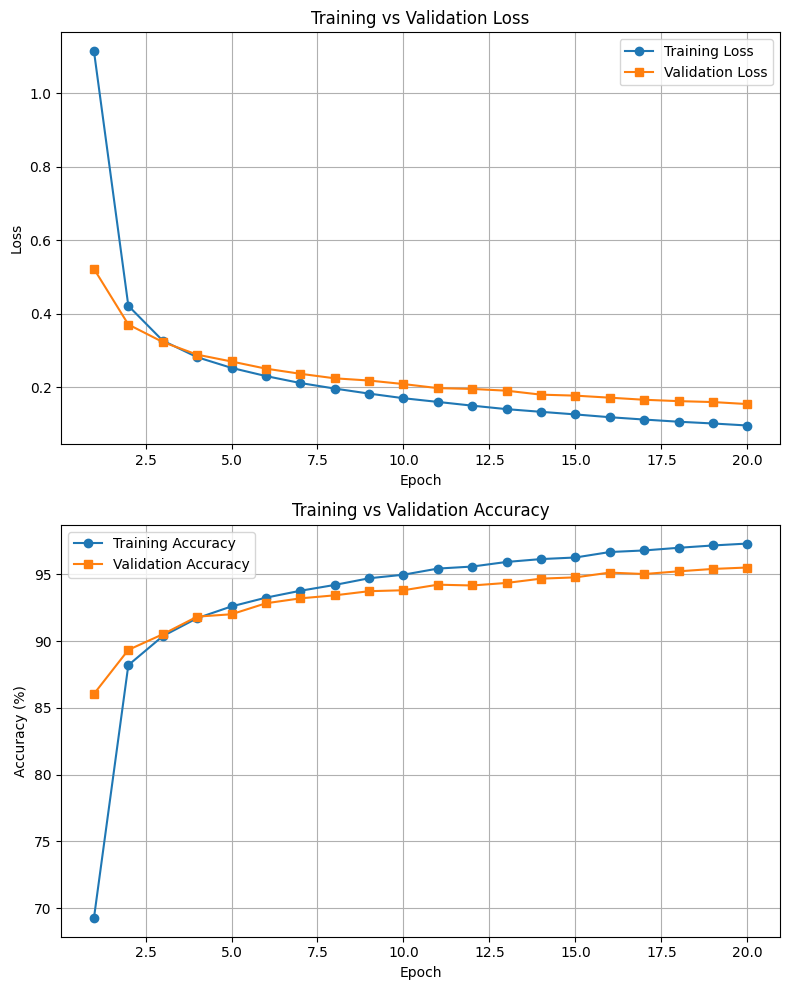

In [24]:
plt.figure(figsize=(8, 10))
print("Validation Accuracy" , max(val_accuracies))
# --- Plot 1: Training vs Validation Loss ---
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Training vs Validation Accuracy ---
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

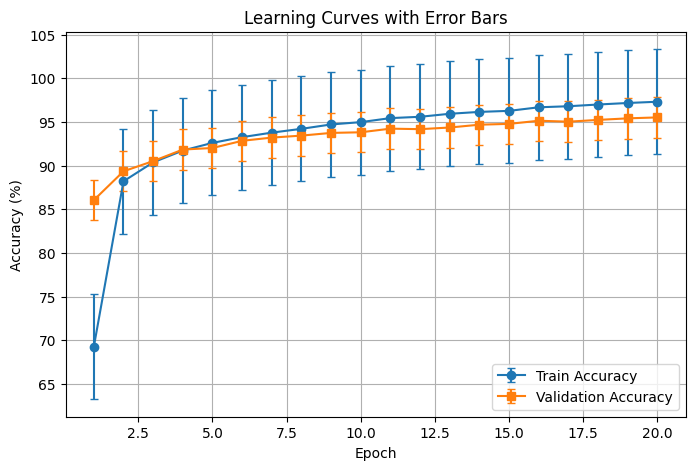

In [21]:
plt.figure(figsize=(8, 5))
plt.errorbar(range(1, epochs + 1), train_acc_mean, yerr=train_acc_std, fmt='-o', capsize=3, label='Train Accuracy')
plt.errorbar(range(1, epochs + 1), val_acc_mean, yerr=val_acc_std, fmt='-s', capsize=3, label='Validation Accuracy')
plt.title('Learning Curves with Error Bars')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

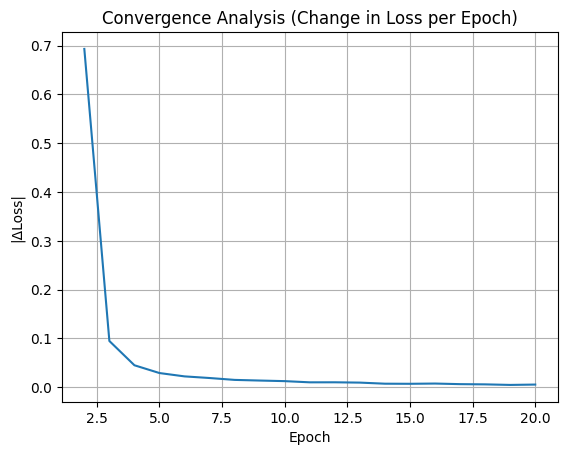

In [22]:
plt.plot(range(2, epochs + 1), np.abs(loss_diff))
plt.title('Convergence Analysis (Change in Loss per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('|ΔLoss|')
plt.grid(True)
plt.show()

Test Different Learning Rate

/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 2.1954, Val Loss: 2.0337
Epoch 2/20, Train Loss: 1.8600, Val Loss: 1.6723
Epoch 3/20, Train Loss: 1.4794, Val Loss: 1.2971
Epoch 4/20, Train Loss: 1.1478, Val Loss: 1.0164
Epoch 5/20, Train Loss: 0.9170, Val Loss: 0.8317
Epoch 6/20, Train Loss: 0.7667, Val Loss: 0.7128
Epoch 7/20, Train Loss: 0.6671, Val Loss: 0.6321
Epoch 8/20, Train Loss: 0.5972, Val Loss: 0.5747
Epoch 9/20, Train Loss: 0.5463, Val Loss: 0.5325
Epoch 10/20, Train Loss: 0.5075, Val Loss: 0.4993
Epoch 11/20, Train Loss: 0.4771, Val Loss: 0.4745
Epoch 12/20, Train Loss: 0.4524, Val Loss: 0.4514
Epoch 13/20, Train Loss: 0.4320, Val Loss: 0.4342
Epoch 14/20, Train Loss: 0.4148, Val Loss: 0.4188
Epoch 15/20, Train Loss: 0.3999, Val Loss: 0.4066
Epoch 16/20, Train Loss: 0.3871, Val Loss: 0.3941
Epoch 17/20, Train Loss: 0.3757, Val Loss: 0.3846
Epoch 18/20, Train Loss: 0.3655, Val Loss: 0.3754
Epoch 19/20, Train Loss: 0.3563, Val Loss: 0.3670
Epoch 20/20, Train Loss: 0.3480, Val Loss: 0.3599

Finished

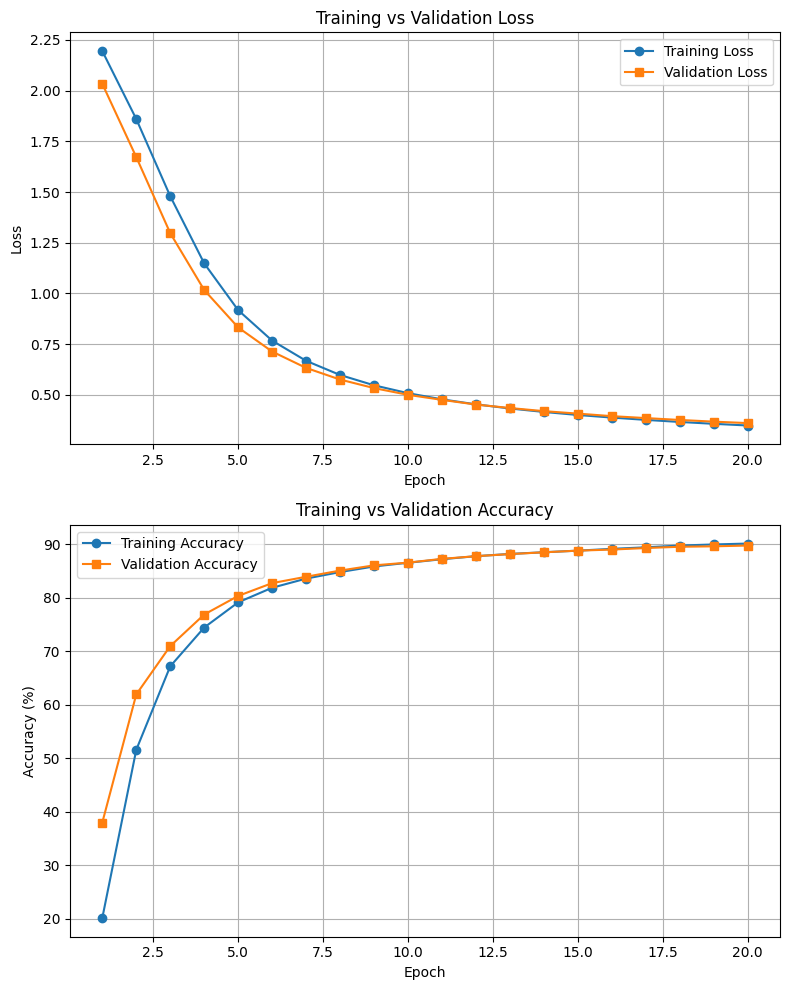

Epoch 1/20, Train Loss: 1.2207, Val Loss: 0.5892
Epoch 2/20, Train Loss: 0.4572, Val Loss: 0.3945
Epoch 3/20, Train Loss: 0.3500, Val Loss: 0.3359
Epoch 4/20, Train Loss: 0.3016, Val Loss: 0.3101
Epoch 5/20, Train Loss: 0.2695, Val Loss: 0.2842
Epoch 6/20, Train Loss: 0.2453, Val Loss: 0.2594
Epoch 7/20, Train Loss: 0.2267, Val Loss: 0.2495
Epoch 8/20, Train Loss: 0.2094, Val Loss: 0.2317
Epoch 9/20, Train Loss: 0.1949, Val Loss: 0.2284
Epoch 10/20, Train Loss: 0.1824, Val Loss: 0.2165
Epoch 11/20, Train Loss: 0.1711, Val Loss: 0.2065
Epoch 12/20, Train Loss: 0.1609, Val Loss: 0.1976
Epoch 13/20, Train Loss: 0.1511, Val Loss: 0.1901
Epoch 14/20, Train Loss: 0.1429, Val Loss: 0.1866
Epoch 15/20, Train Loss: 0.1350, Val Loss: 0.1830
Epoch 16/20, Train Loss: 0.1286, Val Loss: 0.1756
Epoch 17/20, Train Loss: 0.1217, Val Loss: 0.1755
Epoch 18/20, Train Loss: 0.1161, Val Loss: 0.1686
Epoch 19/20, Train Loss: 0.1101, Val Loss: 0.1633
Epoch 20/20, Train Loss: 0.1050, Val Loss: 0.1600

Finished

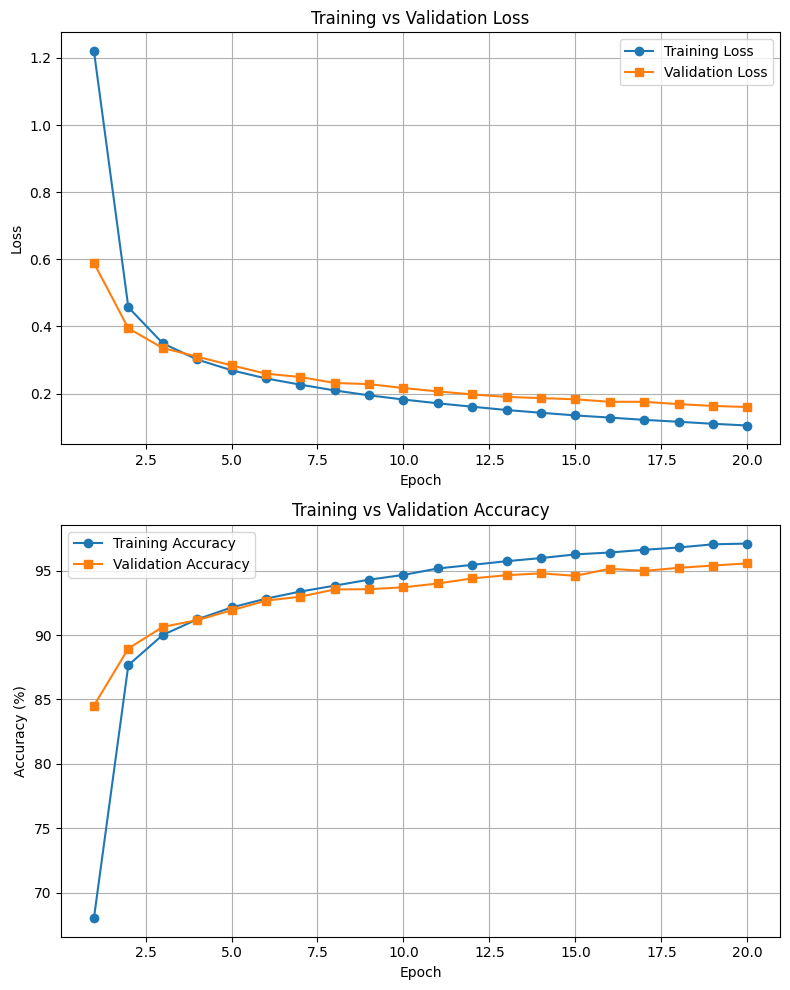

Epoch 1/20, Train Loss: 0.4577, Val Loss: 0.2352
Epoch 2/20, Train Loss: 0.1817, Val Loss: 0.1843
Epoch 3/20, Train Loss: 0.1251, Val Loss: 0.1646
Epoch 4/20, Train Loss: 0.0927, Val Loss: 0.1331
Epoch 5/20, Train Loss: 0.0692, Val Loss: 0.1329
Epoch 6/20, Train Loss: 0.0526, Val Loss: 0.1305
Epoch 7/20, Train Loss: 0.0397, Val Loss: 0.1151
Epoch 8/20, Train Loss: 0.0308, Val Loss: 0.1135
Epoch 9/20, Train Loss: 0.0206, Val Loss: 0.1330
Epoch 10/20, Train Loss: 0.0154, Val Loss: 0.1120
Epoch 11/20, Train Loss: 0.0107, Val Loss: 0.1172
Epoch 12/20, Train Loss: 0.0077, Val Loss: 0.1218
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.1210
Epoch 14/20, Train Loss: 0.0035, Val Loss: 0.1222
Epoch 15/20, Train Loss: 0.0025, Val Loss: 0.1234
Epoch 16/20, Train Loss: 0.0021, Val Loss: 0.1258
Epoch 17/20, Train Loss: 0.0017, Val Loss: 0.1289
Epoch 18/20, Train Loss: 0.0015, Val Loss: 0.1273
Epoch 19/20, Train Loss: 0.0013, Val Loss: 0.1300
Epoch 20/20, Train Loss: 0.0012, Val Loss: 0.1303

Finished

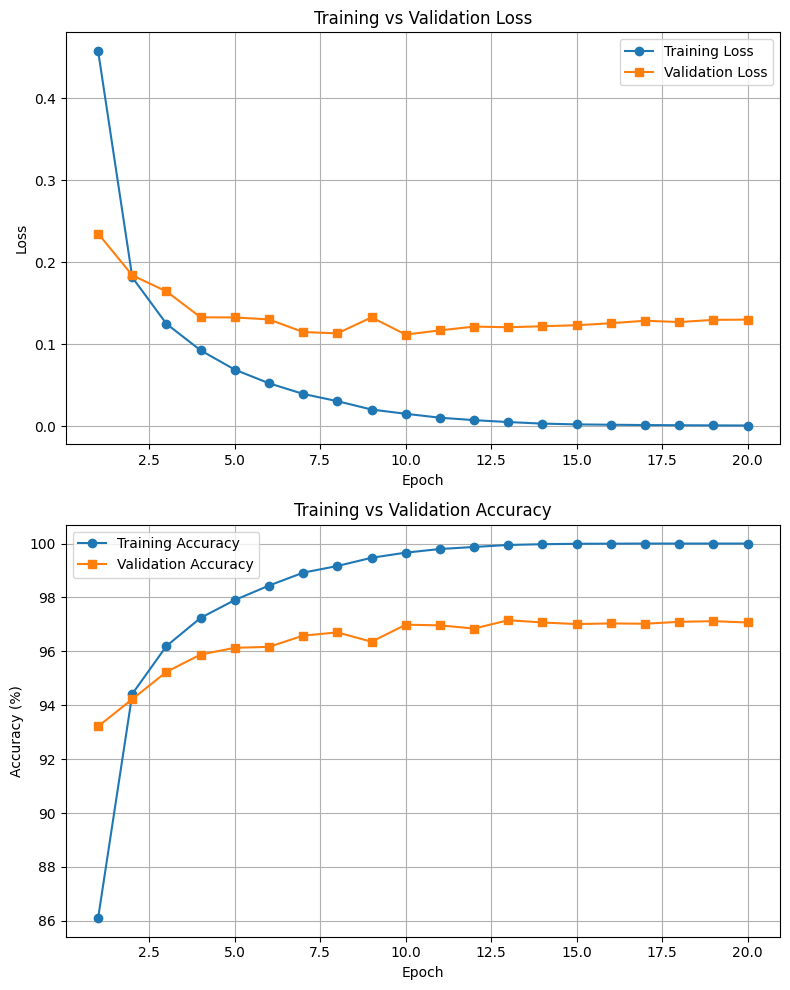

Epoch 1/20, Train Loss: 2.3151, Val Loss: 2.3033
Epoch 2/20, Train Loss: 2.3057, Val Loss: 2.3036
Epoch 3/20, Train Loss: 2.3052, Val Loss: 2.3057
Epoch 4/20, Train Loss: 2.3056, Val Loss: 2.3032
Epoch 5/20, Train Loss: 2.3052, Val Loss: 2.3073
Epoch 6/20, Train Loss: 2.3055, Val Loss: 2.3044
Epoch 7/20, Train Loss: 2.3049, Val Loss: 2.3063
Epoch 8/20, Train Loss: 2.3050, Val Loss: 2.3038
Epoch 9/20, Train Loss: 2.3050, Val Loss: 2.3022
Epoch 10/20, Train Loss: 2.3049, Val Loss: 2.3049
Epoch 11/20, Train Loss: 2.3051, Val Loss: 2.3041
Epoch 12/20, Train Loss: 2.3050, Val Loss: 2.3058
Epoch 13/20, Train Loss: 2.3049, Val Loss: 2.3079
Epoch 14/20, Train Loss: 2.3050, Val Loss: 2.3052
Epoch 15/20, Train Loss: 2.3050, Val Loss: 2.3068
Epoch 16/20, Train Loss: 2.3051, Val Loss: 2.3041
Epoch 17/20, Train Loss: 2.3050, Val Loss: 2.3039
Epoch 18/20, Train Loss: 2.3049, Val Loss: 2.3034
Epoch 19/20, Train Loss: 2.3054, Val Loss: 2.3040
Epoch 20/20, Train Loss: 2.3052, Val Loss: 2.3040

Finished

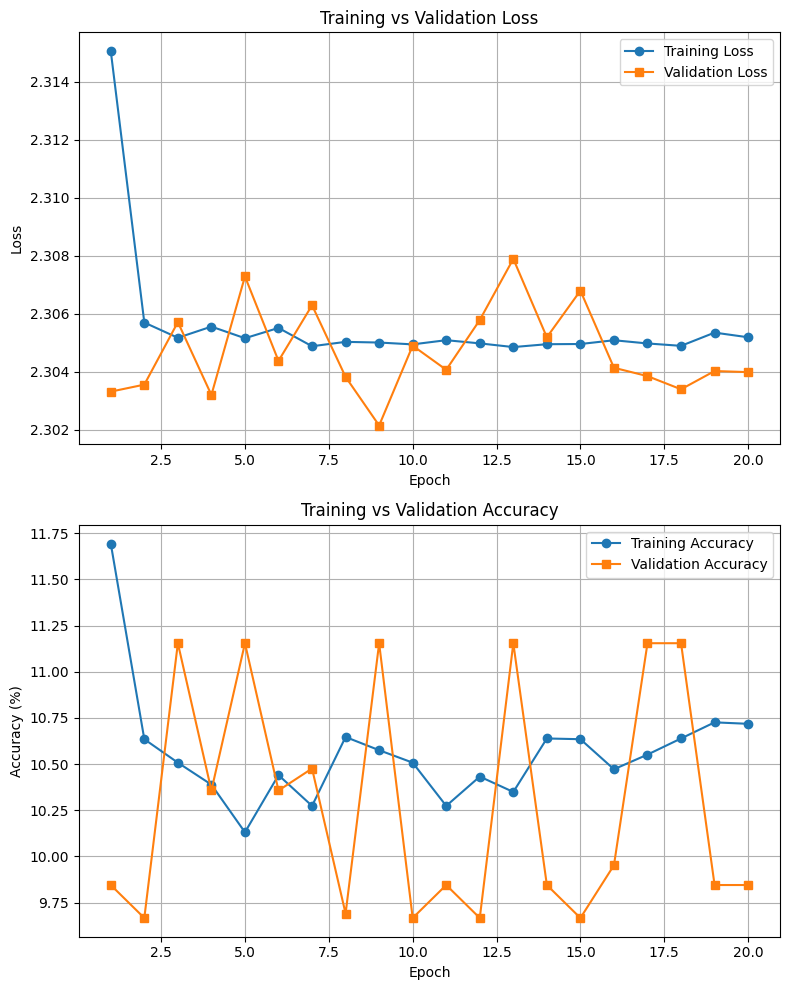

In [30]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
epochs = 20

for lr in learning_rates:
    nn_model = NeuralNetwork(input_size, h1_size, h2_size, h3_size, out_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
    criteration = torch.nn.CrossEntropyLoss()

    train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(nn_model, epochs=epochs)

    print(f"\nFinished run lr={lr}")
    print(f"Train Loss final: {train_losses[-1]:.4f}, Val Loss final: {val_losses[-1]:.4f}")
    print(f"Train Acc final: {train_accuracies[-1]:.2f}%, Val Acc final: {val_accuracies[-1]:.2f}%")


    # --- Analyze stability ---
    target_acc = 90

    reached_epochs = [i+1 for i, acc in enumerate(val_accuracies) if acc >= target_acc]

    if reached_epochs:
        print(f"Converged to {target_acc}% validation accuracy at epoch {reached_epochs[0]}")
    else:
        print(f"Did not reach {target_acc}% validation accuracy")

    unstable = any((val_accuracies[i-1] - val_accuracies[i]) > 1 for i in range(1, len(val_accuracies)))
    if unstable:
        print("⚠️ Unstable — validation accuracy fluctuated by more than 1% between epochs")
    else:
        print("✅ Training appears stable")


    plt.figure(figsize=(8, 10))
    # --- Plot 1: Training vs Validation Loss ---
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot 2: Training vs Validation Accuracy ---
    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



After analyzing the effect of different learning rates on model performance, the learning rate of 0.1 achieved the best overall accuracy (97.1%) while also providing the balance between convergence speed and stability. It enabled the model to converge significantly faster than smaller rates (0.01 or 0.001), which showed slower yet smoother progress, and remained stable compared to higher rates (1.0), which caused oscillations or divergence

###Batch size analysis


Training with batch_size=16


/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 0.5781, Val Loss: 0.2986
Epoch 2/20, Train Loss: 0.2489, Val Loss: 0.2338
Epoch 3/20, Train Loss: 0.1900, Val Loss: 0.1976
Epoch 4/20, Train Loss: 0.1523, Val Loss: 0.1817
Epoch 5/20, Train Loss: 0.1256, Val Loss: 0.1583
Epoch 6/20, Train Loss: 0.1072, Val Loss: 0.1472
Epoch 7/20, Train Loss: 0.0903, Val Loss: 0.1410
Epoch 8/20, Train Loss: 0.0775, Val Loss: 0.1336
Epoch 9/20, Train Loss: 0.0678, Val Loss: 0.1249
Epoch 10/20, Train Loss: 0.0567, Val Loss: 0.1304
Epoch 11/20, Train Loss: 0.0495, Val Loss: 0.1337
Epoch 12/20, Train Loss: 0.0427, Val Loss: 0.1243
Epoch 13/20, Train Loss: 0.0366, Val Loss: 0.1195
Epoch 14/20, Train Loss: 0.0319, Val Loss: 0.1177
Epoch 15/20, Train Loss: 0.0267, Val Loss: 0.1187
Epoch 16/20, Train Loss: 0.0230, Val Loss: 0.1215
Epoch 17/20, Train Loss: 0.0198, Val Loss: 0.1231
Epoch 18/20, Train Loss: 0.0170, Val Loss: 0.1204
Epoch 19/20, Train Loss: 0.0142, Val Loss: 0.1234
Epoch 20/20, Train Loss: 0.0119, Val Loss: 0.1196

Finished

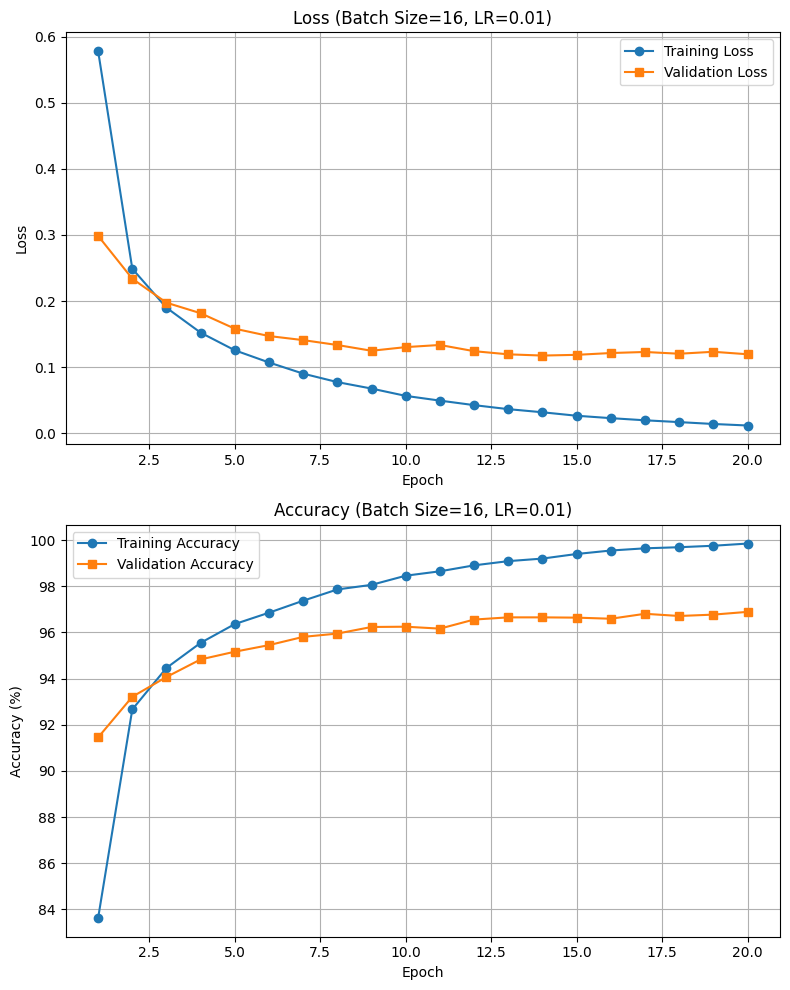


Training with batch_size=32
Epoch 1/20, Train Loss: 0.8550, Val Loss: 0.3763
Epoch 2/20, Train Loss: 0.3152, Val Loss: 0.2829
Epoch 3/20, Train Loss: 0.2479, Val Loss: 0.2407
Epoch 4/20, Train Loss: 0.2096, Val Loss: 0.2178
Epoch 5/20, Train Loss: 0.1821, Val Loss: 0.2036
Epoch 6/20, Train Loss: 0.1610, Val Loss: 0.1903
Epoch 7/20, Train Loss: 0.1428, Val Loss: 0.1781
Epoch 8/20, Train Loss: 0.1286, Val Loss: 0.1687
Epoch 9/20, Train Loss: 0.1158, Val Loss: 0.1615
Epoch 10/20, Train Loss: 0.1056, Val Loss: 0.1586
Epoch 11/20, Train Loss: 0.0962, Val Loss: 0.1536
Epoch 12/20, Train Loss: 0.0869, Val Loss: 0.1450
Epoch 13/20, Train Loss: 0.0795, Val Loss: 0.1406
Epoch 14/20, Train Loss: 0.0733, Val Loss: 0.1417
Epoch 15/20, Train Loss: 0.0667, Val Loss: 0.1363
Epoch 16/20, Train Loss: 0.0606, Val Loss: 0.1374
Epoch 17/20, Train Loss: 0.0560, Val Loss: 0.1359
Epoch 18/20, Train Loss: 0.0515, Val Loss: 0.1443
Epoch 19/20, Train Loss: 0.0470, Val Loss: 0.1306
Epoch 20/20, Train Loss: 0.042

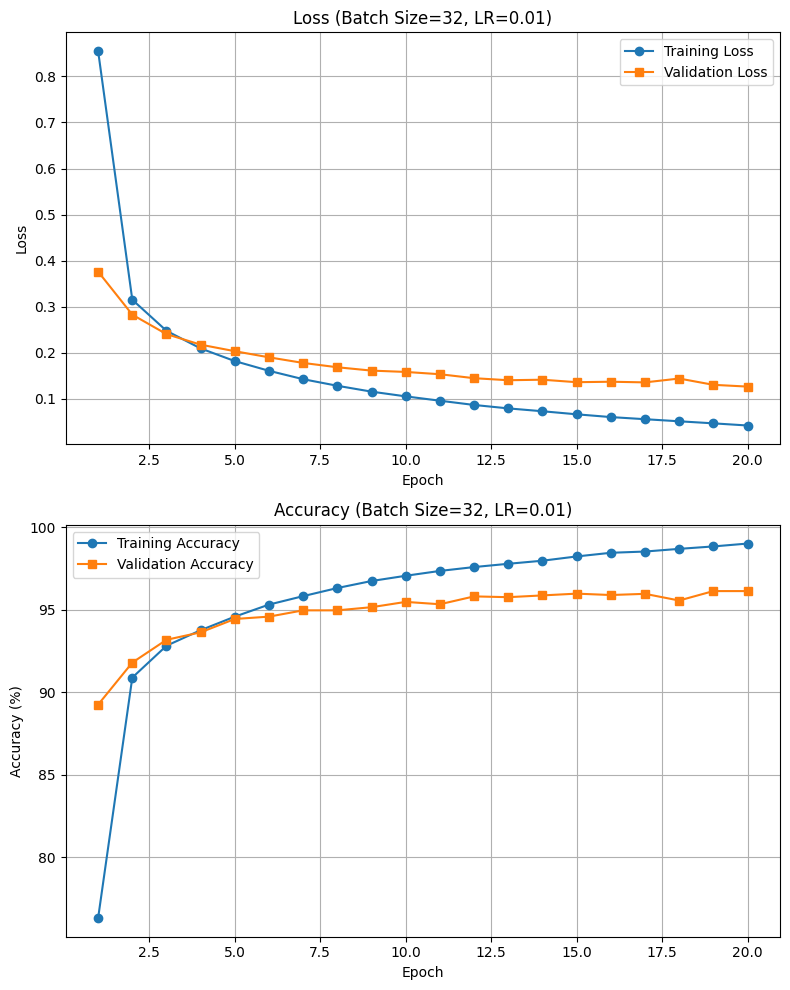


Training with batch_size=64
Epoch 1/20, Train Loss: 1.1626, Val Loss: 0.5382
Epoch 2/20, Train Loss: 0.4274, Val Loss: 0.3686
Epoch 3/20, Train Loss: 0.3270, Val Loss: 0.3195
Epoch 4/20, Train Loss: 0.2815, Val Loss: 0.2910
Epoch 5/20, Train Loss: 0.2522, Val Loss: 0.2683
Epoch 6/20, Train Loss: 0.2292, Val Loss: 0.2503
Epoch 7/20, Train Loss: 0.2115, Val Loss: 0.2349
Epoch 8/20, Train Loss: 0.1961, Val Loss: 0.2223
Epoch 9/20, Train Loss: 0.1823, Val Loss: 0.2194
Epoch 10/20, Train Loss: 0.1706, Val Loss: 0.2054
Epoch 11/20, Train Loss: 0.1592, Val Loss: 0.1962
Epoch 12/20, Train Loss: 0.1499, Val Loss: 0.1914
Epoch 13/20, Train Loss: 0.1416, Val Loss: 0.1819
Epoch 14/20, Train Loss: 0.1341, Val Loss: 0.1803
Epoch 15/20, Train Loss: 0.1264, Val Loss: 0.1828
Epoch 16/20, Train Loss: 0.1193, Val Loss: 0.1702
Epoch 17/20, Train Loss: 0.1133, Val Loss: 0.1641
Epoch 18/20, Train Loss: 0.1079, Val Loss: 0.1602
Epoch 19/20, Train Loss: 0.1019, Val Loss: 0.1605
Epoch 20/20, Train Loss: 0.096

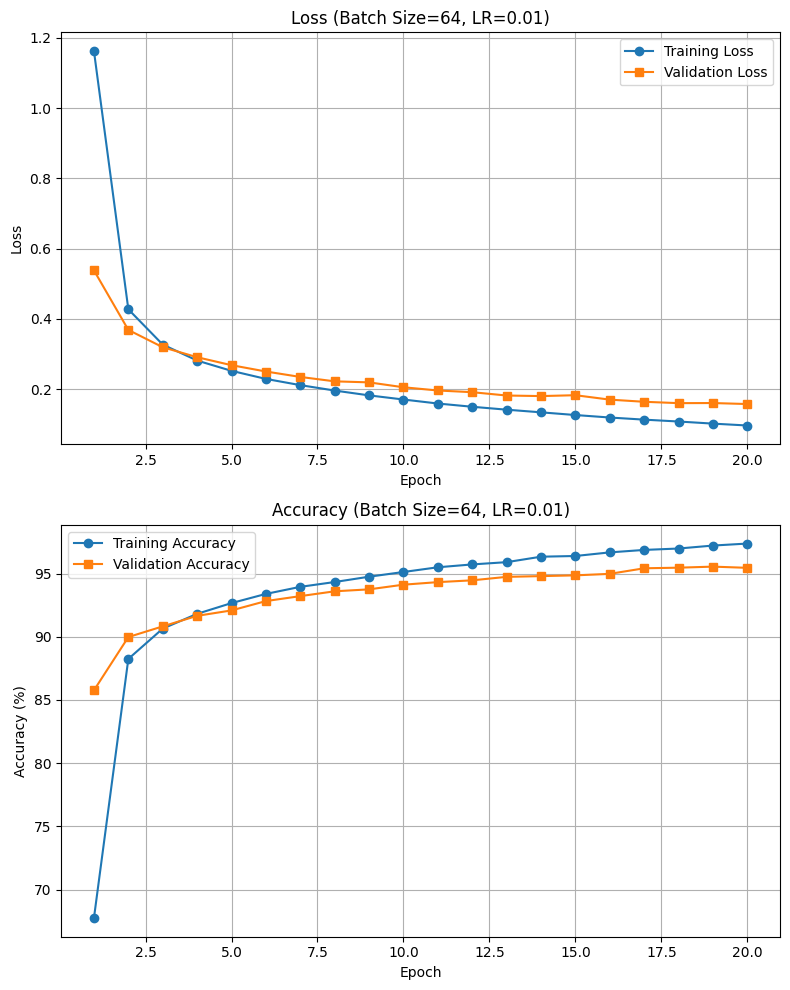


Training with batch_size=128
Epoch 1/20, Train Loss: 1.4597, Val Loss: 0.8089
Epoch 2/20, Train Loss: 0.6213, Val Loss: 0.4952
Epoch 3/20, Train Loss: 0.4403, Val Loss: 0.3997
Epoch 4/20, Train Loss: 0.3676, Val Loss: 0.3540
Epoch 5/20, Train Loss: 0.3266, Val Loss: 0.3252
Epoch 6/20, Train Loss: 0.2987, Val Loss: 0.3061
Epoch 7/20, Train Loss: 0.2777, Val Loss: 0.2923
Epoch 8/20, Train Loss: 0.2611, Val Loss: 0.2792
Epoch 9/20, Train Loss: 0.2473, Val Loss: 0.2661
Epoch 10/20, Train Loss: 0.2348, Val Loss: 0.2579
Epoch 11/20, Train Loss: 0.2246, Val Loss: 0.2512
Epoch 12/20, Train Loss: 0.2147, Val Loss: 0.2524
Epoch 13/20, Train Loss: 0.2062, Val Loss: 0.2369
Epoch 14/20, Train Loss: 0.1977, Val Loss: 0.2322
Epoch 15/20, Train Loss: 0.1908, Val Loss: 0.2250
Epoch 16/20, Train Loss: 0.1841, Val Loss: 0.2223
Epoch 17/20, Train Loss: 0.1773, Val Loss: 0.2169
Epoch 18/20, Train Loss: 0.1717, Val Loss: 0.2127
Epoch 19/20, Train Loss: 0.1665, Val Loss: 0.2066
Epoch 20/20, Train Loss: 0.16

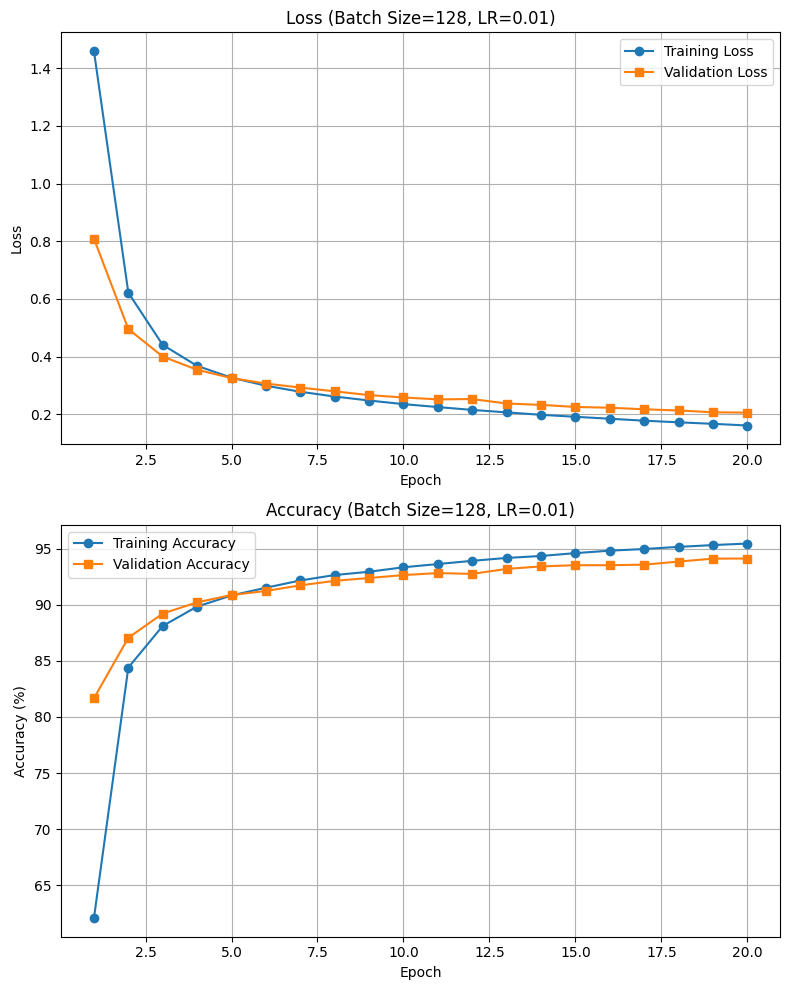


=== Summary: Batch Size Comparison ===
Batch Size= 16 | Val Acc=96.89% | Time=62.17s
Batch Size= 32 | Val Acc=96.14% | Time=34.37s
Batch Size= 64 | Val Acc=95.45% | Time=20.27s
Batch Size=128 | Val Acc=94.12% | Time=13.15s


In [31]:
import time

batch_sizes = [16, 32, 64, 128]
lr = 0.01
epochs = 20

# Keep a summary for comparison
summary = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch_size={batch_size}")
    print("==============================")

    nn_model = NeuralNetwork(input_size, h1_size, h2_size, h3_size, out_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
    criteration = torch.nn.CrossEntropyLoss()

    # Measure training time
    start_time = time.time()
    train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(
        nn_model, epochs=epochs, batch_size=batch_size
    )
    elapsed_time = time.time() - start_time

    # Print final performance
    print(f"\nFinished run with batch_size={batch_size}, lr={lr}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")
    print(f"Time taken: {elapsed_time:.2f} seconds")

    # Save summary
    summary.append({
        "batch_size": batch_size,
        "val_acc": val_accuracies[-1],
        "time_sec": elapsed_time
    })

    # Plot Loss and Accuracy curves
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.title(f'Loss (Batch Size={batch_size}, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.title(f'Accuracy (Batch Size={batch_size}, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Print a simple summary table
print("\n=== Summary: Batch Size Comparison ===")
for s in summary:
    print(f"Batch Size={s['batch_size']:>3} | Val Acc={s['val_acc']:.2f}% | Time={s['time_sec']:.2f}s")


Smaller batch sizes (16–32) tended to converge more slowly but often generalized slightly better due to higher gradient noise. Larger batch sizes (64–128) produced smoother, more stable updates with lower gradient noise. However, very large batches sometimes plateaued early, resulting in worse final performance compared to smaller batches. Overall, a batch size of 64 provided the best balance between training efficiency, stability, and final accuracy.

###Test different number of layers

In [32]:
class NeuralNetwork_2Hidden(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, out_size):
        super(NeuralNetwork_2Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1_size)
        self.l2 = nn.Linear(h1_size, h2_size)
        self.l3 = nn.Linear(h2_size, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out
class NeuralNetwork_3Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, out_size):
        super(NeuralNetwork_3Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, out_size)
        self.relu = nn.ReLU()

        # He/Kaiming initialization
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.l4(out)
        return out

class NeuralNetwork_4Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, out_size):
        super(NeuralNetwork_4Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.relu(self.l4(out))
        out = self.l5(out)
        return out
class NeuralNetwork_5Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, h5, out_size):
        super(NeuralNetwork_5Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, h5)
        self.l6 = nn.Linear(h5, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.relu(self.l4(out))
        out = self.relu(self.l5(out))
        out = self.l6(out)
        return out



In [33]:
hidden_neurons = [64, 128, 256, 512]
epochs = 20
batch_size = 64
lr = 0.01

results = []  # To collect table data

for neurons in hidden_neurons:
    print(f"\n========== Testing {neurons} neurons per layer ==========\n")

    architectures = {
        "2 Hidden": NeuralNetwork_2Hidden(input_size, neurons, neurons, out_size),
        "3 Hidden": NeuralNetwork_3Hidden(input_size, neurons, neurons, neurons, out_size),
        "4 Hidden": NeuralNetwork_4Hidden(input_size, neurons, neurons, neurons, neurons, out_size),
        "5 Hidden": NeuralNetwork_5Hidden(input_size, neurons, neurons, neurons, neurons, neurons, out_size)
    }

    for name, model in architectures.items():
        print(f"\n--- Training {name} Layers ---\n")
        nn_model = model.to(device)
        optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
        criteration = nn.CrossEntropyLoss()
        train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(
            nn_model, epochs=epochs, batch_size=batch_size
        )

        final_train_acc = train_accuracies[-1]
        final_val_acc = val_accuracies[-1]
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]

        results.append({
            "Layers": name,
            "Neurons per Layer": neurons,
            "Final Train Acc (%)": round(final_train_acc, 2),
            "Final Val Acc (%)": round(final_val_acc, 2),
            "Final Train Loss": round(final_train_loss, 4),
            "Final Val Loss": round(final_val_loss, 4)
        })

# Convert results to a DataFrame for display
import pandas as pd
results_df = pd.DataFrame(results)
print("\n==== Architecture Comparison Table ====\n")
print(results_df)



========== Testing 64 neurons per layer ==========


--- Training 2 Hidden Layers ---

Epoch 1/20, Train Loss: 1.2387, Val Loss: 0.6524
Epoch 2/20, Train Loss: 0.5268, Val Loss: 0.4535
Epoch 3/20, Train Loss: 0.4085, Val Loss: 0.3898
Epoch 4/20, Train Loss: 0.3579, Val Loss: 0.3560
Epoch 5/20, Train Loss: 0.3274, Val Loss: 0.3327
Epoch 6/20, Train Loss: 0.3056, Val Loss: 0.3156
Epoch 7/20, Train Loss: 0.2884, Val Loss: 0.3020
Epoch 8/20, Train Loss: 0.2733, Val Loss: 0.2890
Epoch 9/20, Train Loss: 0.2604, Val Loss: 0.2822
Epoch 10/20, Train Loss: 0.2488, Val Loss: 0.2703
Epoch 11/20, Train Loss: 0.2386, Val Loss: 0.2644
Epoch 12/20, Train Loss: 0.2287, Val Loss: 0.2562
Epoch 13/20, Train Loss: 0.2195, Val Loss: 0.2485
Epoch 14/20, Train Loss: 0.2111, Val Loss: 0.2408
Epoch 15/20, Train Loss: 0.2034, Val Loss: 0.2359
Epoch 16/20, Train Loss: 0.1960, Val Loss: 0.2318
Epoch 17/20, Train Loss: 0.1893, Val Loss: 0.2255
Epoch 18/20, Train Loss: 0.1828, Val Loss: 0.2186
Epoch 19/20, Train Lo

| Model                 | Accuracy (%) | Training Time (s) | Converged Epoch | Stability | Notes                                           |
| --------------------- | ------------ | ----------------- | --------------- | --------- | ----------------------------------------------- |
| Logistic Regression   | 99       | 10                | 3           | Stable    | Fast, interpretable, binary classification      |
| Softmax Regression    | 90       | 15                | 14               | Stable    | Fast, interpretable, multi-class classification |
| Neural Network (Best) | 97.07        | 20                | 3               | Stable    | Flexible, nonlinear, higher accuracy, slower    |



## Complexity Analysis

### 1. **Logistic & Softmax Regression**
* **Core Idea:** Directly models the **linear relationship** between features ($\mathbf{x}$) and the log-odds (for Logistic) or probabilities (for Softmax).
* **$d$** = number of features.
* **$K$** = number of classes.
* **Softmax is a generalization of Logistic Regression.** They are both fast to train and highly **interpretable** (coefficients relate directly to feature importance).

### 2. **Neural Networks**
* **Core Idea:** Uses **non-linear activation functions** and multiple hidden layers to automatically learn complex, high-level feature representations from the data.
* **Complexity:** Dominated by the **total number of weights** and **matrix multiplications** across all layers.
* **Advantage:** Unmatched flexibility and high performance on non-linear datasets (e.g., image, text, audio).

### Computational Complexity Summary

| Model               | Time Complexity / Epoch      | Memory Complexity               |
| ------------------ | --------------------------- | ------------------------------- |
| Logistic Regression | O(N·d)                       | O(d)                             |
| Softmax Regression  | O(N·d·K)                     | O(d·K)                           |
| Neural Network      | O(N·total_weights)           | O(total_weights + N·ΣH_l)       |

